In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.1 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext('local[*]')
spark = SparkSession(sc)

In [ ]:
# Loading pyspark libraries for KMeans
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# Loading other required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Loading dataset
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Encoding Gender
def change_gender(item):
    if item == "Male":
        return 0
    else:
        return 1

df["Gender"] = df["Gender"].apply(change_gender,1)
df = df[["Gender","Age","Annual Income (k$)","Spending Score (1-100)"]]

In [ ]:
# Converting pandas dataframe into spark dataframe
from pyspark.sql.types import StructType, StructField, NumericType
spark_df = spark.createDataFrame(df)

In [ ]:
from pyspark.ml.feature import VectorAssembler
features = tuple(df.columns)
features

('Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)')

In [ ]:
# Making a spark dataframe
assembler = VectorAssembler(inputCols=features,outputCol="features")
dataset = assembler.transform(spark_df)
dataset.select("features").show(truncate=False)

+--------------------+
|features            |
+--------------------+
|[0.0,19.0,15.0,39.0]|
|[0.0,21.0,15.0,81.0]|
|[1.0,20.0,16.0,6.0] |
|[1.0,23.0,16.0,77.0]|
|[1.0,31.0,17.0,40.0]|
|[1.0,22.0,17.0,76.0]|
|[1.0,35.0,18.0,6.0] |
|[1.0,23.0,18.0,94.0]|
|[0.0,64.0,19.0,3.0] |
|[1.0,30.0,19.0,72.0]|
|[0.0,67.0,19.0,14.0]|
|[1.0,35.0,19.0,99.0]|
|[1.0,58.0,20.0,15.0]|
|[1.0,24.0,20.0,77.0]|
|[0.0,37.0,20.0,13.0]|
|[0.0,22.0,20.0,79.0]|
|[1.0,35.0,21.0,35.0]|
|[0.0,20.0,21.0,66.0]|
|[0.0,52.0,23.0,29.0]|
|[1.0,35.0,23.0,98.0]|
+--------------------+
only showing top 20 rows



In [ ]:
# Creating KMeans 
kmeans = KMeans().setK(5).setSeed(42)
model = kmeans.fit(dataset)

predictions = model.transform(dataset)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouetter with squared euclidean distance = {}".format(silhouette))

cost = model.computeCost(dataset)
print("Within set sum of squared errors = {}".format(cost))

print("Cluster Centers: ")
ctr = []
centers = model.clusterCenters()

for center in centers:
    ctr.append(center)
    print(center)

Silhouetter with squared euclidean distance = 0.587334158384376
Within set sum of squared errors = 79501.91330865488
Cluster Centers: 
[ 0.56818182 24.45454545 39.         65.65909091]
[ 0.60344828 50.89655172 55.5        48.77586207]
[ 0.48648649 40.32432432 87.43243243 18.18918919]
[ 0.53846154 32.69230769 86.53846154 82.12820513]
[ 0.59090909 44.31818182 25.77272727 20.27272727]


In [ ]:
centers = pd.DataFrame(ctr,columns=features)
centers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.568182,24.454545,39.000000,65.659091
1,0.603448,50.896552,55.500000,48.775862
2,0.486486,40.324324,87.432432,18.189189
3,0.538462,32.692308,86.538462,82.128205
4,0.590909,44.318182,25.772727,20.272727


In [ ]:
predictions_df = predictions.toPandas()
predictions_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),features,prediction
0,0,19,15,39,"[0.0, 19.0, 15.0, 39.0]",4
1,0,21,15,81,"[0.0, 21.0, 15.0, 81.0]",0
2,1,20,16,6,"[1.0, 20.0, 16.0, 6.0]",4
3,1,23,16,77,"[1.0, 23.0, 16.0, 77.0]",0
4,1,31,17,40,"[1.0, 31.0, 17.0, 40.0]",4


In [ ]:
predictions_df[predictions_df["prediction"] == 0]["Annual Income (k$)"].values

array([15, 16, 17, 18, 19, 19, 20, 20, 21, 23, 24, 25, 28, 28, 29, 30, 33,
       33, 34, 37, 38, 39, 39, 40, 40, 40, 42, 43, 46, 46, 48, 48, 54, 54,
       54, 57, 59, 60, 61, 62, 63, 64, 65, 65])

In [ ]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


In [ ]:
zero_income = predictions_df[predictions_df["prediction"] == 0]["Annual Income (k$)"].values
zero_spendingScore = predictions_df[predictions_df["prediction"] == 0]["Spending Score (1-100)"].values

one_income = predictions_df[predictions_df["prediction"] == 1]["Annual Income (k$)"].values
one_spendingScore = predictions_df[predictions_df["prediction"] == 1]["Spending Score (1-100)"].values

two_income = predictions_df[predictions_df["prediction"] == 2]["Annual Income (k$)"].values
two_spendingScore = predictions_df[predictions_df["prediction"] == 2]["Spending Score (1-100)"].values

three_income = predictions_df[predictions_df["prediction"] == 3]["Annual Income (k$)"].values
three_spendingScore = predictions_df[predictions_df["prediction"] == 3]["Spending Score (1-100)"].values

four_income = predictions_df[predictions_df["prediction"] == 4]["Annual Income (k$)"].values
four_spendingScore = predictions_df[predictions_df["prediction"] == 4]["Spending Score (1-100)"].values

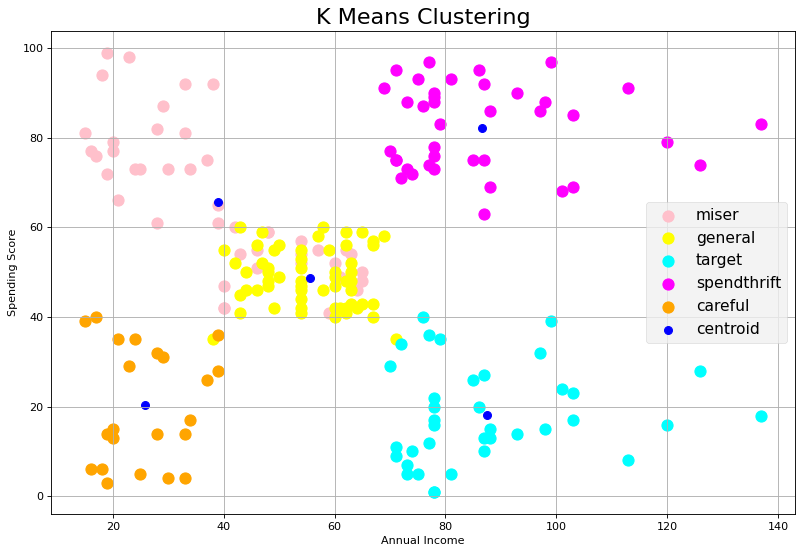

In [ ]:
from matplotlib.pyplot import figure

fig = figure(figsize=(12,8), dpi=80)
plt.scatter(zero_income,zero_spendingScore,s=100,c='pink',label='miser')
plt.scatter(one_income,one_spendingScore,s=100,c='yellow',label='general')
plt.scatter(two_income,two_spendingScore,s=100,c='cyan',label='target')
plt.scatter(three_income,three_spendingScore,s=100,c='magenta',label='spendthrift')
plt.scatter(four_income,four_spendingScore,s=100,c='orange',label='careful')
plt.scatter(centers["Annual Income (k$)"],centers["Spending Score (1-100)"],s=50,c='blue',label='centroid')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()